Este cuadernillo contiene todo el código empleado para realizar la parte de nuestro TFM relativa al análisis del dataset Youtube Video Trending Dataset. Incluye las siguientes secciones:

- Instalación de subprogramas y librerías
- Preprocesamiento de los datos
- Obtención y análisis de características de los datos

## Instalación de subprogramas y librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import isodate #para manejar formato de duración ISO 8601
import re #para manejar expresiones regulares
from textblob import TextBlob

## Preprocesamiento de datos

In [2]:
# PASO 1: LECTURA DEL ARCHIVO
df = pd.read_csv("youtube_trending_videos_global.csv", low_memory=False)

In [3]:
# El primer paso del preprocesado es eliminar columnas que consideramos innecesarias para el estudio. Estas son: 
# channel_id,video_dimension, channel_have_hidden_subscribers, channel_localized_title, channel_localized_description
elim_columns = ['channel_id','video_dimension', 'channel_have_hidden_subscribers', 'channel_localized_title', 'channel_localized_description']
df = df.drop(columns=elim_columns)

In [4]:
#Debemos eliminar las filas con video_id nulo, ya que esa será la variable principal para la identificación de los vídeos.
#Según los metadatos ofrecidos por Kaggle, hay 13 instancias de ese tipo.
df = df.dropna(subset=['video_id'])

In [5]:
#A continuación trataremos el resto de valores NaN.
#Para columnas alfanuméricas (string), cambiar por ""
#Para columnas numéricas,
alfanumeric_values = {"video_trending_country": "", "video_description": "", "video_category_id": "", "video_tags": ""}

#de momento no

In [6]:
#Guardamos el dataset resultante en un csv para evitar repetir el proceso
df.to_csv('ytvg_clean.csv', index=False)

In [7]:
#Creamos un dataset auxiliar que contenga solamente una instancia de cada vídeo. Es decir, deberá tener unas 180.000 instancias.
df_unique = df.drop_duplicates(subset=['video_id'], keep='first')
df_unique.to_csv('ytvg_unique.csv', index=False)

## Obtención y análisis de características

In [12]:
df = pd.read_csv("ytvg_unique.csv")

In [3]:
df.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'video_title', 'video_description',
       'video_default_thumbnail', 'video_category_id', 'video_tags',
       'video_duration', 'video_definition', 'video_licensed_content',
       'video_view_count', 'video_like_count', 'video_comment_count',
       'channel_title', 'channel_description', 'channel_custom_url',
       'channel_published_at', 'channel_country', 'channel_view_count',
       'channel_subscriber_count', 'channel_video_count'],
      dtype='object')

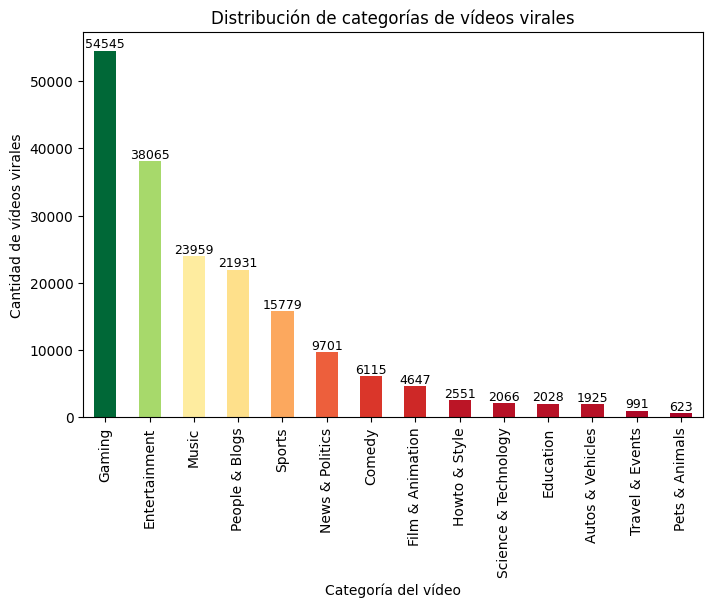

In [4]:
#Análisis de categorías
categories = df['video_category_id'].value_counts()
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de categorías de vídeos virales")
plt.xlabel("Categoría del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [5]:
#Análisis de duración. Formato de la duración: ISO 8601
#Transformar todas las duraciones a segundos.
df["video_duration_segs"] = df["video_duration"].apply(lambda x: int(isodate.parse_duration(x).total_seconds()))
df["video_duration_segs"].describe()

count    185223.000000
mean       2348.640957
std        5264.193158
min           0.000000
25%         174.000000
50%         758.000000
75%        1695.000000
max      158651.000000
Name: video_duration_segs, dtype: float64

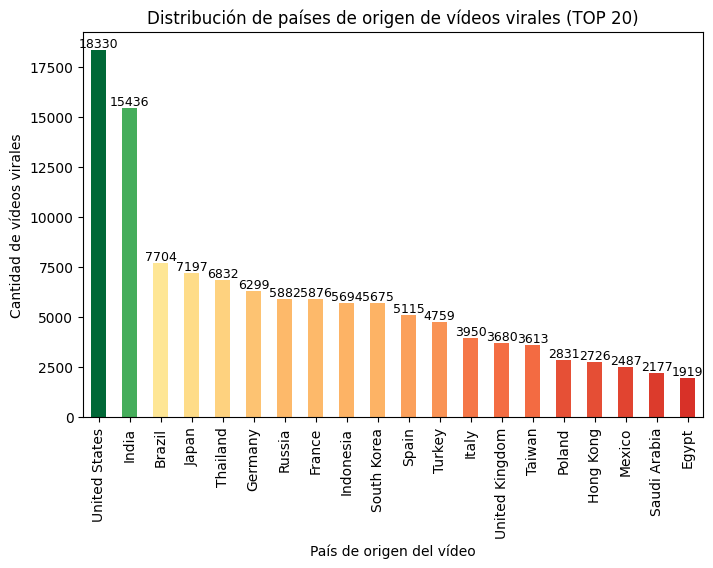

In [6]:
#País de origen de los vídeos
categories = df['channel_country'].value_counts()
categories = categories[0:20]
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de países de origen de vídeos virales (TOP 20)")
plt.xlabel("País de origen del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [7]:
#Análisis de título (idioma, tamaño, emojis)

In [8]:
#Ratio visitas-suscriptores

## Preprocesamiento títulos - análisis de sentimientos

In [9]:
#funcion para extraer algunas características del título
def extract_features(df):
    df['title_length'] = df['video_title'].apply(lambda x: len(str(x)))
    df['title_word_count'] = df['video_title'].apply(lambda x: len(str(x).split()))
    df['title_has_exclamation'] = df['video_title'].apply(lambda x: '!' in str(x))
    df['title_has_question'] = df['video_title'].apply(lambda x: '?' in str(x))
    df['title_sentiment'] = df['video_title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['description_length'] = df['video_description'].apply(lambda x: len(str(x)))
    df['description_sentiment'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

In [13]:
df_preproc = df
df_preproc = extract_features(df_preproc)

# 2. Eliminar columnas irrelevantes
cols_to_drop = [
    'video_id', 'channel_id', 'video_title', 'video_description', 'video_default_thumbnail',
    'channel_title', 'channel_description', 'channel_custom_url', 'channel_localized_title',
    'channel_localized_description', 'thumbnail_url_hq', 'published_at'
]
cols_to_drop += ['video_tags', 'channel_country']  # Si tienen muchos nulos y no son críticas
df_preproc.drop(columns=[col for col in cols_to_drop if col in df_preproc.columns], inplace=True)

# 3. Imputar valores nulos
num_cols = df_preproc.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df_preproc[col].fillna(df_preproc[col].median(), inplace=True)
cat_cols = df_preproc.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc[col].fillna('Unknown', inplace=True)

# 4. Codificar variables categóricas
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    df_preproc[col] = LabelEncoder().fit_transform(df_preproc[col])

# 5. Estandarizar variables numéricas
from sklearn.preprocessing import StandardScaler
num_cols = df_preproc.select_dtypes(include=['float64', 'int64']).columns.drop(['viral_score'], errors='ignore')
scaler = StandardScaler()
df_preproc[num_cols] = scaler.fit_transform(df_preproc[num_cols])

C:\Users\belga\AppData\Local\Temp\ipykernel_8492\1140775893.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_preproc[col].fillna(df_preproc[col].median(), inplace=True)
C:\Users\belga\AppData\Local\Temp\ipykernel_8492\1140775893.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [14]:
df_preproc

,video_published_at,video_trending__date,video_trending_country,video_category_id,video_duration,video_definition,video_licensed_content,video_view_count,video_like_count,video_comment_count,...,channel_view_count,channel_subscriber_count,channel_video_count,title_length,title_word_count,title_has_exclamation,title_has_question,title_sentiment,description_length,description_sentiment
0,-1.666140,-1.867158,1.493661,0.341539,0.165476,-0.062773,False,6.482217,22.234123,37.686487,...,-0.192032,0.588224,-0.268870,-0.767424,-0.722222,False,False,-0.131682,-0.558346,-0.373998
1,-1.665602,-1.867158,1.493661,2.028219,-1.310178,-0.062773,True,1.044966,-0.225381,0.377163,...,-0.198288,-0.187478,-0.106227,0.643044,0.568896,False,False,-0.131682,-0.540723,-0.373998
2,-1.662870,-1.867158,1.493661,-0.333132,0.732882,-0.062773,True,0.023463,0.831287,2.359928,...,-0.225451,-0.205337,-0.259276,-0.725939,-0.076663,False,False,-0.131682,0.414435,-0.373998
3,-1.666040,-1.867158,1.493661,2.028219,-1.309979,-0.062773,True,0.976928,-0.225381,0.517584,...,-0.198288,-0.187478,-0.106227,0.933435,0.568896,False,False,-0.131682,0.175939,-0.373998
4,-1.677745,-1.867158,1.493661,-0.670468,0.162097,-0.062773,True,0.311261,0.460445,0.456553,...,-0.234451,-0.309339,-0.268410,1.638669,1.429642,False,False,-0.131682,0.175939,0.708771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185218,1.688283,1.107798,-1.090263,-0.333132,0.866237,-0.062773,True,-0.255682,-0.281592,-0.255228,...,-0.236335,-0.312127,-0.260621,-1.431173,-1.798154,False,False,-0.131682,0.071377,1.238637
185219,1.665811,1.107798,-1.090263,-0.333132,2.054511,15.930385,True,-0.255638,-0.283323,-0.255228,...,-0.236026,-0.310612,-0.259524,-2.011954,-1.798154,False,False,-0.131682,-0.618263,-0.220414
185220,1.680387,1.107798,-1.090263,-0.333132,-0.589741,15.930385,True,-0.255893,-0.282265,-0.255228,...,-0.236295,-0.311756,-0.263701,-1.638595,-1.582967,False,False,-0.131682,-0.694629,-0.373998
185221,1.687087,1.107798,-1.090263,-0.333132,0.148384,-0.062773,True,-0.256075,-0.282596,-0.255228,...,-0.236077,-0.310403,-0.264728,-1.057814,-0.507035,True,False,-0.131682,-0.693454,-0.373998


In [ ]:
# 6. Definir X e y para regresión
X = df_preproc.drop(['viral_score'], axis=1, errors='ignore')
y = df_preproc['viral_score']

# 7. Dividir en train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)